<a href="https://colab.research.google.com/github/sriksmachi/sriksml/blob/main/language-models/transformers_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [33]:
import tensorflow as tf
from tensorflow import matmul, cast, float32,sqrt, math, transpose
from tensorflow import convert_to_tensor, string
from keras.backend import softmax
from numpy import random
from tensorflow.keras.layers import TextVectorization, Embedding, Layer, Dropout, Input
from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
import pathlib
import pickle
import random
import re
import unicodedata
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from tensorflow import convert_to_tensor, int64
from pickle import load
from numpy.random import shuffle


## Positional Embedding Layer

In [38]:
# Positional embedding matrix
def pos_enc_matrix(L, d, n=1000):
  assert d % 2 == 0
  d2 = d // 2
  P = np.zeros((L, d))
  # creates a 1d array of evenly spaced values and converting it into column vector
  k = np.arange(L).reshape(-1, 1)
  i = np.arange(d2).reshape(1,-1)
  denom = np.power(n, -i/d2) # n ** (-2*i/d)
  args = k * denom
  P[:, ::2] = np.sin(args)
  P[:, 1::2] = np.cos(args)
  return P

pos_matrix = pos_enc_matrix(4, 4)
assert pos_matrix.shape == (4,4)
print(pos_matrix.shape)
print(pos_matrix)


(4, 4)
[[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.03161751  0.99950004]
 [ 0.90929743 -0.41614684  0.0632034   0.99800067]
 [ 0.14112001 -0.9899925   0.09472609  0.99550337]]


In [94]:
# Positional Embedding

class PositionalEmbeddingLayer(Layer):
  def __init__(self, max_seq_len, vocab_size, output_dim, **kwargs):
    super(PositionalEmbeddingLayer, self).__init__(**kwargs)
    self.word_embedding_layer = Embedding(vocab_size, output_dim, mask_zero=True)
    self.max_seq_len = max_seq_len
    self.output_dim = output_dim
    self.vocab_size = vocab_size

  def compute_mask(self, *args, **kwargs):
      return self.word_embedding_layer.compute_mask(*args, **kwargs)

  def call(self, inputs):
    embedded_words = self.word_embedding_layer(inputs)
    embedded_positions = pos_enc_matrix(self.max_seq_len, self.output_dim)
    return embedded_words + tf.constant(embedded_positions, dtype = "float32")

In [95]:
my_embedding_layer = PositionalEmbeddingLayer(9, 1000, 512)
print(my_embedding_layer(tf.constant([[1, 2, 3, 4, 5, 6, 7, 8, 9]])).shape)

(1, 9, 512)



## Self Attention Layer

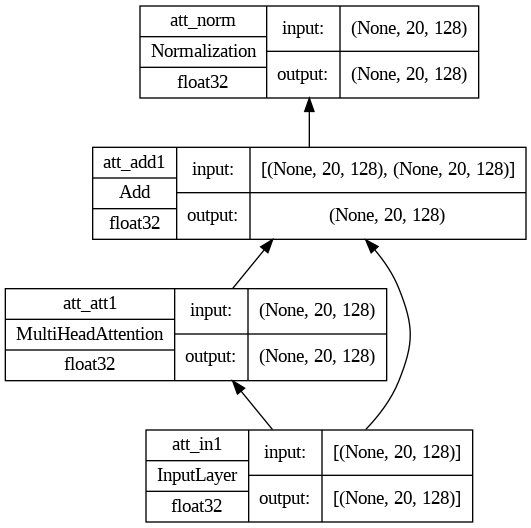

In [84]:
def self_attention(input_shape, num_heads=8, key_dim=128, pref="att", mask=False, **kwargs):
  inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{pref}_in1")
  attention = tf.keras.layers.MultiHeadAttention(num_heads, key_dim, name=f"{pref}_att1", **kwargs)
  norm = tf.keras.layers.Normalization(name=f"{pref}_norm")
  add = tf.keras.layers.Add(name=f"{pref}_add1")
  att_out = attention(query=inputs, value=inputs, key=inputs, use_causal_mask=mask)
  outputs = norm(add([inputs, att_out]))
  model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{pref}_att")
  return model

model = self_attention(input_shape=[20, 128])
tf.keras.utils.plot_model(model, "self_attention.png", show_shapes=True, show_dtype=True,
                          show_layer_names=True, rankdir='BT', show_layer_activations=True)

## Cross Attention Layer

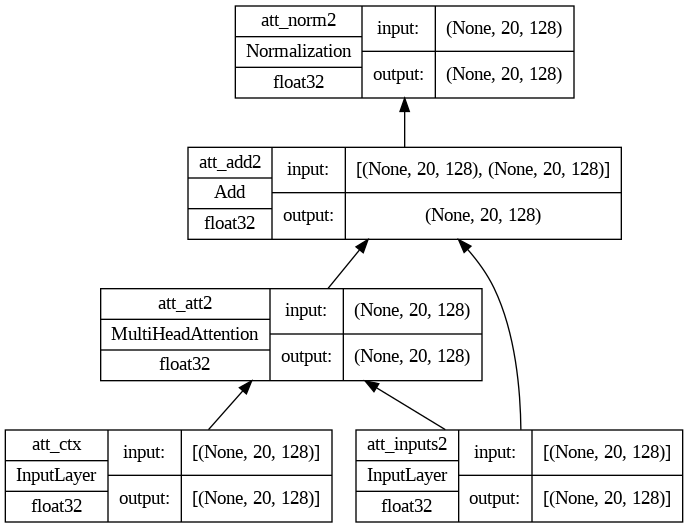

In [85]:
def cross_attention(input_shape, context_shape, num_heads=8, key_dim=128, pref="att", **kwargs):
  context = tf.keras.layers.Input(shape=context_shape, name=f"{pref}_ctx")
  inputs = tf.keras.layers.Input(shape=input_shape, name=f"{pref}_inputs2")
  attention = tf.keras.layers.MultiHeadAttention(num_heads, key_dim, name=f"{pref}_att2", **kwargs)
  norm = tf.keras.layers.Normalization(name=f"{pref}_norm2")
  add = tf.keras.layers.Add(name=f"{pref}_add2")
  att_out = attention(query=inputs, value=context, key=context)
  outputs = norm(add([inputs, att_out]))
  model = tf.keras.Model(inputs=[(inputs, context)], outputs=outputs, name=f"{pref}_cross")
  return model

model = cross_attention(input_shape=[20, 128], context_shape=[20, 128])
tf.keras.utils.plot_model(model, "cross_attention.png", show_shapes=True, show_dtype=True,
                          show_layer_names=True, rankdir='BT', show_layer_activations=True)


## Feedforward Layer

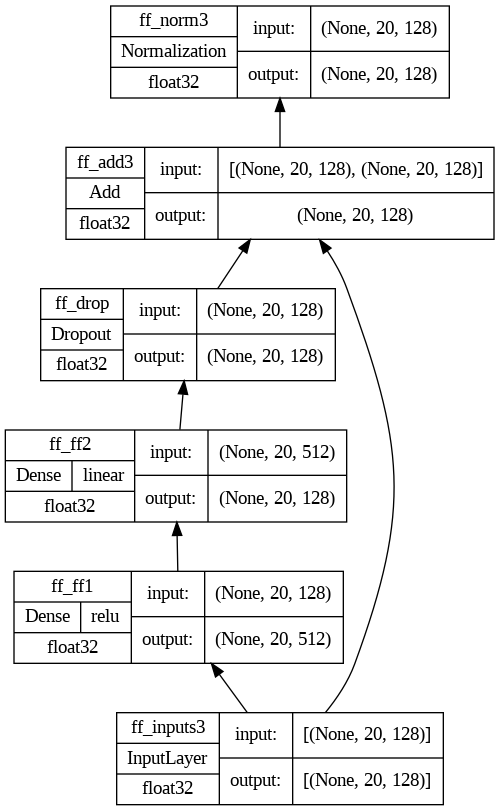

In [88]:
def feedforward(input_shape, model_dim, ff_dim, dropout=0.1, pref='ff', **kwargs):
  inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f'{pref}_inputs3')
  dense1 = tf.keras.layers.Dense(ff_dim, name=f'{pref}_ff1', activation='relu')
  dense2 = tf.keras.layers.Dense(model_dim, name=f'{pref}_ff2')
  drop = tf.keras.layers.Dropout(dropout, name=f'{pref}_drop')
  add = tf.keras.layers.Add(name=f"{pref}_add3")
  ffout = drop(dense2(dense1(inputs)))
  norm = tf.keras.layers.Normalization(name=f"{pref}_norm3")
  outputs = norm(add([inputs, ffout]))
  model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{pref}_ff")
  return model

model = feedforward(input_shape=(20, 128), model_dim=128, ff_dim=512)
tf.keras.utils.plot_model(model, "feedforward.png", show_shapes=True, show_dtype=True,
                          show_layer_names=True, rankdir='BT', show_layer_activations=True)



## Encoder Layer

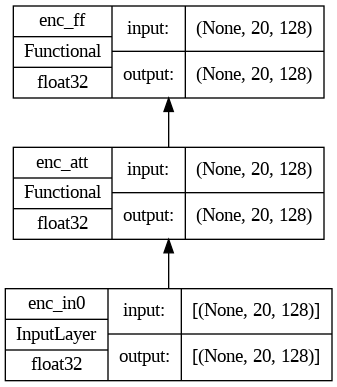

In [91]:


def encoder(input_shape, key_dim, ff_dim, dropout=0.1, pref="enc", **kwargs):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{pref}_in0"),
      self_attention(input_shape, pref=pref, key_dim=key_dim, mask=False, **kwargs),
      feedforward(input_shape, key_dim, ff_dim, dropout, pref)
  ])
  return model


model = encoder(input_shape=(20, 128), key_dim=128, ff_dim=512)
tf.keras.utils.plot_model(model, "encoder.png", show_shapes=True, show_dtype=True,
                          show_layer_names=True, rankdir='BT', show_layer_activations=True)



## Decoder Layer

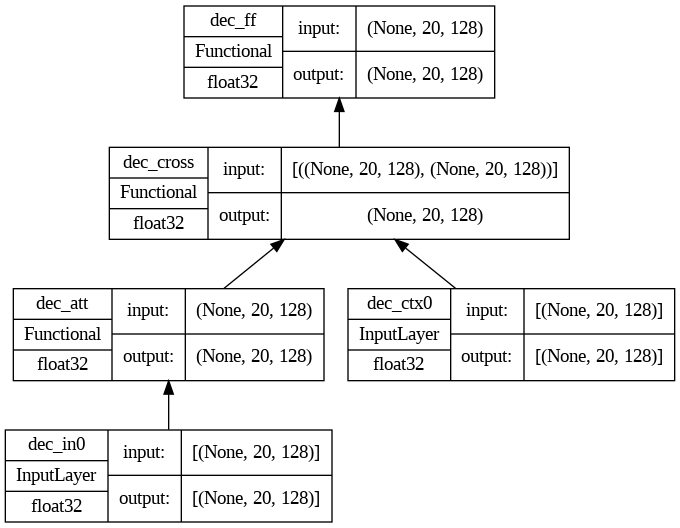

In [93]:
def decoder(input_shape, key_dim, ff_dim, dropout=0.1, pref="dec", **kwargs):
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{pref}_in0")
    context = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{pref}_ctx0")
    attmodel = self_attention(input_shape, key_dim=key_dim, mask=True, pref=pref, **kwargs)
    crossmodel = cross_attention(input_shape, input_shape, key_dim=key_dim, pref=pref, **kwargs)
    ffmodel = feedforward(input_shape, key_dim, ff_dim, dropout, pref)
    x = attmodel(inputs)
    x = crossmodel([(context, x)])
    output = ffmodel(x)
    model = tf.keras.Model(inputs=[(inputs, context)], outputs=output, name=pref)
    return model

seq_length = 20
key_dim = 128
ff_dim = 512
num_heads = 8
model = decoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim,
                num_heads=num_heads)
tf.keras.utils.plot_model(model, "decoder.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

## Transformer Model

In [100]:
def transformer(num_layers, num_heads, seq_len, key_dim, ff_dim, vocab_size_src, vocab_size_trgt, dropout=0.1, name='transformer'):
  emb_shape = (seq_len, key_dim)
  # layers
  inp_enc = tf.keras.layers.Input(shape=(seq_len, ), dtype='float32', name='encoder_inputs')
  inp_dec =  tf.keras.layers.Input(shape=(seq_len, ), dtype='float32', name='decoder_inputs')
  embed_enc = PositionalEmbeddingLayer(seq_len, vocab_size_src, key_dim)
  embed_dec = PositionalEmbeddingLayer(seq_len, vocab_size_trgt, key_dim)
  encoders = [encoder(input_shape=emb_shape, key_dim=key_dim, ff_dim=ff_dim, dropout=dropout, pref=f"enc{i}", num_heads=num_heads) for i in range(num_layers)]
  decoders = [decoder(input_shape=emb_shape, key_dim=key_dim, ff_dim=ff_dim, dropout=dropout, pref=f"dec{i}", num_heads=num_heads) for i in range(num_layers)]
  final = tf.keras.layers.Dense(vocab_size_trgt, name='linear')
  # build
  x1 = embed_enc(inp_enc)
  x2 = embed_dec(inp_dec)
  for layer in encoders:
    x1 = layer(x1)
  for layer in decoders:
    x2 = layer([x2, x1])
  output = final(x2)
  try:
    del output._keras_mask
  except AttributeError:
    pass
  model = tf.keras.Model(inputs=[inp_enc, inp_dec], outputs=output, name=name)
  return model

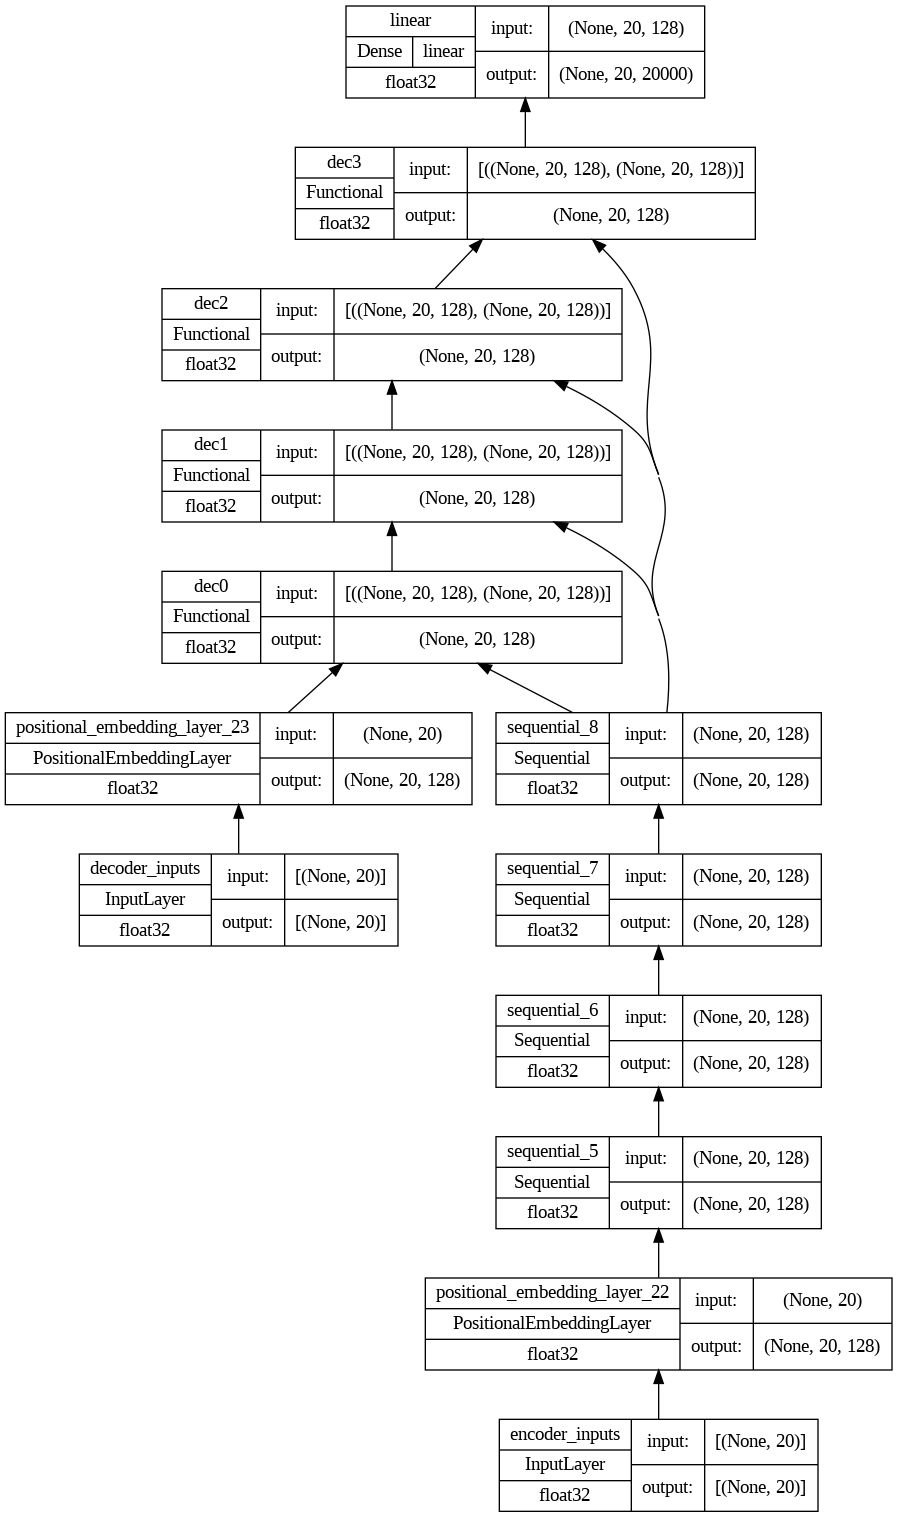

In [101]:
seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
vocab_size_en = 10000
vocab_size_fr = 20000
model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, vocab_size_fr, dropout)
tf.keras.utils.plot_model(model, "transformer.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

## Training Utilities

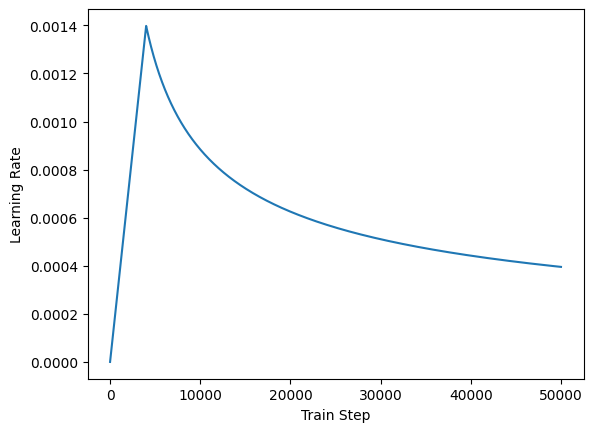

In [102]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, key_dim, warmup_steps=4000):
    super().__init__()
    self.key_dim=key_dim
    self.warmup_steps=warmup_steps
    self.d=tf.cast(self.key_dim, tf.float32)

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    config = {
        "key_dim": self.key_dim,
        "warmup_steps": self.warmup_steps
    }
    return config

key_dim = 128
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
import matplotlib.pyplot as plt
import tensorflow as tf

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    "Custom learning rate for Adam optimizer"
    def __init__(self, key_dim, warmup_steps=4000):
        super().__init__()
        self.key_dim = key_dim
        self.warmup_steps = warmup_steps
        self.d = tf.cast(self.key_dim, tf.float32)

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        # to make save and load a model using custom layer possible0
        config = {
            "key_dim": self.key_dim,
            "warmup_steps": self.warmup_steps,
        }
        return config

key_dim = 128
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
plt.plot(lr(tf.range(50000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

In [105]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = loss_object(label, pred)
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, dtype=pred.dtype)
  match = pred==label
  mask = label !=0
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match) / tf.reduce_sum(mask)


## Final Model

In [106]:
vocab_size_en = 10000
vocab_size_fr = 20000
seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, vocab_size_fr, dropout)
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, 20)]                 0         []                            
 )                                                                                                
                                                                                                  
 positional_embedding_layer  (None, 20, 128)              1280000   ['encoder_inputs[0][0]']      
 _24 (PositionalEmbeddingLa                                                                       
 yer)                                                                                             
                                                                                                  
 sequential_9 (Sequential)   (None, 20, 128)              659714    ['positional_embeddi

## Preparing the data

In [53]:
# download dataset provided by Anki: https://www.manythings.org/anki/
text_file = tf.keras.utils.get_file(
    fname="fra-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True,
)

text_file = pathlib.Path(text_file).parent / "fra.txt"

def normalize(line):
    """Normalize a line of text and split into two at the tab character"""
    line = unicodedata.normalize("NFKC", line.strip().lower())
    line = re.sub(r"^([^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(\s[^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(?!\s)([^ \w])$", r" \1", line)
    line = re.sub(r"(?!\s)([^ \w]\s)", r" \1", line)
    eng, fra = line.split("\t")
    fra = "[start] " + fra + " [end]"
    return eng, fra

# normalize each line and separate into English and French
with open(text_file) as fp:
    text_pairs = [normalize(line) for line in fp]

# print some samples
for _ in range(5):
    print(random.choice(text_pairs))

with open("text_pairs.pickle", "wb") as fp:
    pickle.dump(text_pairs, fp)

3423204/3423204 [==============================] - 0s 0us/step
("you can't be too careful when you drive a car .", '[start] tu ne pourras jamais être trop prudent lorsque tu conduis une voiture . [end]')
("i'll never forget this experience .", "[start] je n'oublierai jamais cette expérience . [end]")
("tom is still at his grandfather's house .", '[start] tom est toujours chez son grand-père . [end]')
("let's try this .", '[start] essayons ça . [end]')
('are there any books under the desk ?', '[start] y a-t-il quelque livre sous le bureau  ?  [end]')


In [54]:
# find out how many distinct tokens exist
with open("text_pairs.pickle", "rb") as fp:
    text_paris = pickle.load(fp)

eng_tokens, fra_tokens = set(), set()
eng_maxlength, fra_maxlength = 0, 0
for eng, fra in text_paris:
    eng_token, fra_token = eng.split(), fra.split()
    eng_maxlength = max(len(eng_token), eng_maxlength)
    fra_maxlength = max(len(fra_token), fra_maxlength)
    eng_tokens.update(eng_token)
    fra_tokens.update(fra_token)
print(f"Total English tokens = {len(eng_tokens)}")
print(f"Total French tokens = {len(fra_tokens)}")
print(f"Maximum English sequence length = {eng_maxlength}")
print(f"Maximum French sequence length = {fra_maxlength}")

Total English tokens = 14969
Total French tokens = 29219
Maximum English sequence length = 51
Maximum French sequence length = 60


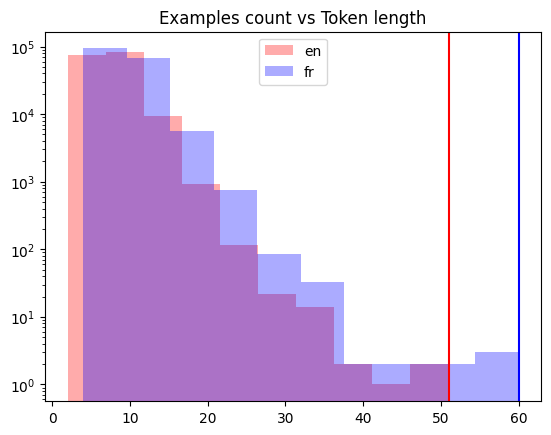

In [55]:
with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

# histogram of sentence length in tokens
en_lengths = [len(eng.split()) for eng, fra in text_pairs]
fr_lengths = [len(fra.split()) for eng, fra in text_pairs]

plt.hist(en_lengths, label="en", color="red", alpha=0.33)
plt.hist(fr_lengths, label="fr", color="blue", alpha=0.33)
plt.yscale("log")     # sentence length fits Benford"s law
plt.ylim(plt.ylim())  # make y-axis consistent for both plots
plt.plot([max(en_lengths), max(en_lengths)], plt.ylim(), color="red")
plt.plot([max(fr_lengths), max(fr_lengths)], plt.ylim(), color="blue")
plt.legend()
plt.title("Examples count vs Token length")
plt.show()

In [111]:
class PrepareDataset:
  def __init__(self, **kwargs):
    super(PrepareDataset, self).__init__(**kwargs)
    self.n_sentences = 1000
    self.train_split = 0.9
    self.vocab_size_eng = 10000
    self.vocab_size_fra = 20000
    self.max_seq_length = 20

  def find_vocab_size(self, tokenizer, dataset):
    tokenizer.fit_on_texts(dataset)
    return len(tokenizer.word_index) + 1

  def format_dataset(self, eng, fra):
    print(eng, fra)
    eng = self.eng_vectorizer(eng)
    fra = self.fra_vectorizer(fra)
    source = { 'encoder_inputs': eng, 'decoder_inputs': fra[:, :-1]}
    target = fra[:, 1:]
    return source, target

  def __call__(self, filename, batch_size=64, **kwargs):

    clean_data = pickle.load(open(filename, 'rb'))
    dataset = clean_data[:self.n_sentences]
    shuffle(dataset)
    train_pairs = dataset[:int(self.train_split * self.n_sentences)]
    test_pairs = dataset[int(self.train_split * self.n_sentences):]

    eng_vectorizer = TextVectorization(
        max_tokens = self.vocab_size_eng,
        standardize = None,
        split = "whitespace",
        output_mode = "int",
        output_sequence_length = self.max_seq_length
    )

    fra_vectorizer = TextVectorization(
        max_tokens = self.vocab_size_fra,
        standardize = None,
        split = "whitespace",
        output_mode = "int",
        output_sequence_length = self.max_seq_length + 1
    )

    train_eng_texts = [pairs[0] for pairs in train_pairs]
    train_fra_texts = [pairs[1] for pairs in train_pairs]

    eng_vectorizer.adapt(train_eng_texts)
    fra_vectorizer.adapt(train_fra_texts)

    self.eng_vectorizer = eng_vectorizer
    self.fra_vectorizer = fra_vectorizer
    self.train = train_pairs
    self.test = test_pairs

    with open("vectorizer.pickle", "wb") as fp:
        data = {
            "train" : train_pairs,
            "test" : test_pairs,
            "eng_vectorizer_weights" : eng_vectorizer.get_weights(),
            "fra_vectorizer_weights" : fra_vectorizer.get_weights(),
            "eng_vectorizer_config" : eng_vectorizer.get_config(),
            "fra_vectorizer_vocab" : fra_vectorizer.get_config()
        }
        pickle.dump(data, fp)

    eng_texts_train, fra_texts_train = zip(*train_pairs)
    eng_texts_test, fra_texts_test = zip(*test_pairs)

    train_ds = tf.data.Dataset.from_tensor_slices((list(eng_texts_train), list(fra_texts_train))).shuffle(2048).batch(batch_size).map(self.format_dataset).prefetch(16).cache()
    test_ds = tf.data.Dataset.from_tensor_slices((list(eng_texts_test), list(fra_texts_test))).shuffle(2048).batch(batch_size).map(self.format_dataset).prefetch(16).cache()

    return train_ds, test_ds

In [112]:
dataset = PrepareDataset()
train_ds, test_ds = dataset( "text_pairs.pickle")
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["encoder_inputs"][0]: {inputs["encoder_inputs"][0]}')
    embed_en = PositionalEmbeddingLayer(20, 10000, 512)
    en_emb = embed_en(inputs["encoder_inputs"])
    print(en_emb.shape)
    print(en_emb._keras_mask.shape)

for inputs, targets in test_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["encoder_inputs"][0]: {inputs["encoder_inputs"][0]}')
    embed_en = PositionalEmbeddingLayer(20, 10000, 512)
    en_emb = embed_en(inputs["encoder_inputs"])
    print(en_emb.shape)
    print(en_emb._keras_mask.shape)



Tensor("args_0:0", shape=(None,), dtype=string) Tensor("args_1:0", shape=(None,), dtype=string)
Tensor("args_0:0", shape=(None,), dtype=string) Tensor("args_1:0", shape=(None,), dtype=string)
inputs["encoder_inputs"].shape: (64, 20)
inputs["encoder_inputs"][0]: [13 71  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(64, 20, 512)
(64, 20)
inputs["encoder_inputs"].shape: (64, 20)
inputs["encoder_inputs"][0]: [13 49  6  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(64, 20, 512)
(64, 20)


## Training

15/15 [==============================] - 68s 3s/step - loss: 9.9171 - masked_accuracy: 0.0000e+00 - val_loss: 9.8600 - val_masked_accuracy: 0.0000e+00


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


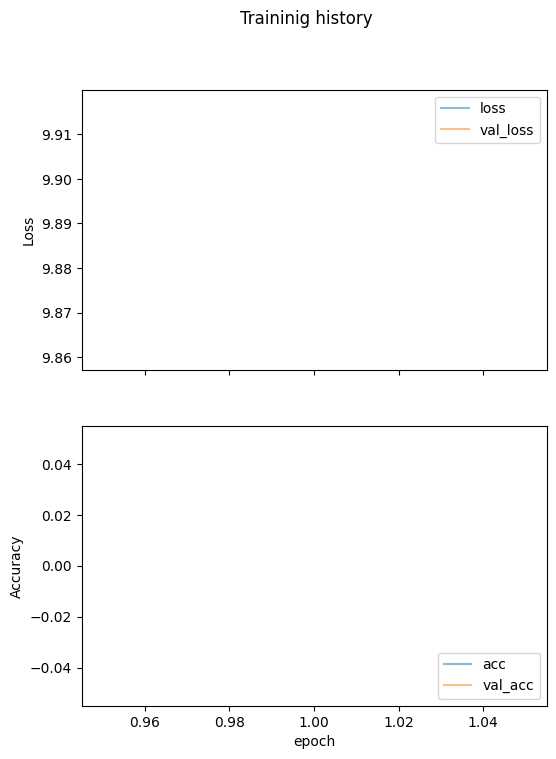

In [113]:
# Create and train the model
seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
vocab_size_en = 10000
vocab_size_fr = 20000
model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, vocab_size_fr, dropout)
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
epochs = 1
history = model.fit(train_ds, epochs=epochs, validation_data=test_ds)

# Save the trained model
model.save("eng-fra-transformer.h5")

# Plot the loss and accuracy history
fig, axs = plt.subplots(2, figsize=(6, 8), sharex=True)
fig.suptitle('Traininig history')
x = list(range(1, epochs+1))
axs[0].plot(x, history.history["loss"], alpha=0.5, label="loss")
axs[0].plot(x, history.history["val_loss"], alpha=0.5, label="val_loss")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(x, history.history["masked_accuracy"], alpha=0.5, label="acc")
axs[1].plot(x, history.history["val_masked_accuracy"], alpha=0.5, label="val_acc")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("epoch")
axs[1].legend(loc="lower right")
plt.show()